# Cifar10 Drift Detection

In this example we will deploy an image classification model along with a drift detector trained on the same dataset. For in depth details on creating a drift detection model for your own dataset see the [alibi-detect project](https://github.com/SeldonIO/alibi-detect) and associated [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/). You can find details for this [CIFAR10 example in their documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_ks_cifar10.html) as well.


Prequisites:

 * [Knative eventing installed](https://knative.dev/docs/install/)
     * Ensure the istio-ingressgateway is exposed as a loadbalancer (no auth in this demo)
 * [Seldon Core installed](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html) 
    * Ensure you install for istio, e.g. for the helm chart `--set istio.enabled=true`
 
 Tested on GKE with Knative 0.13 and Istio 1.3.1

In [ ]:
!pip install -r requirements_notebook.txt

Ensure gateway installed

In [1]:
!kubectl apply -f ../../../notebooks/resources/seldon-gateway.yaml

gateway.networking.istio.io/seldon-gateway unchanged


## Setup Resources

In [2]:
!kubectl create namespace cifar10drift

namespace/cifar10drift created


In [3]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: broker
metadata:
 name: default
 namespace: cifar10drift

Writing broker.yaml


In [4]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [5]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Writing event-display.yaml


In [6]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display created
service/hello-display created


Create the SeldonDeployment image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [8]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: tfserving-cifar10
  namespace: cifar10drift
spec:
  protocol: tensorflow
  transport: rest
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_name=resnet32
          - --model_base_path=gs://seldon-models/tfserving/cifar10/resnet32
          image: tensorflow/serving
          name: resnet32
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
    graph:
      name: resnet32
      type: MODEL
      endpoint:
        service_port: 8501
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10drift/default
    name: model
    replicas: 1


Overwriting cifar10.yaml


In [9]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/tfserving-cifar10 created


Create the pretrained Drift Detector. We forward replies to the message-dumper we started. Notice the `drift_batch_size`. The drift detector will wait until `drify_batch_size` number of requests are received before making a drift prediction.

In [22]:
%%writefile cifar10cd.yaml
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: drift-detector
  namespace: cifar10drift
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.5.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10cd
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/cd/ks/cifar10
        - --reply_url
        - http://hello-display.cifar10drift
        - --event_type
        - io.seldon.serving.inference.drift
        - --event_source
        - io.seldon.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '5000'


Overwriting cifar10cd.yaml


In [23]:
!kubectl apply -f cifar10cd.yaml

service.serving.knative.dev/drift-detector created


Create a Knative trigger to forward logging events to our Outlier Detector.

In [15]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: drift-trigger
  namespace: cifar10drift
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: drift-detector
      namespace: cifar10drift


Overwriting trigger.yaml


In [16]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/drift-trigger created


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [17]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

35.240.18.201


If you are using Kind or Minikube you will need to port-forward to the istio ingressgateway and uncomment the following

In [ ]:
#CLUSTER_IP="localhost:8004"

In [19]:
SERVICE_HOSTNAMES=!(kubectl get ksvc -n cifar10drift drift-detector -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CD)

drift-detector.cifar10drift.35.240.18.201.xip.io


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import tensorflow as tf
tf.keras.backend.clear_session()

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    res = requests.post('http://'+CLUSTER_IP+'/seldon/cifar10drift/tfserving-cifar10/v1/models/resnet32/:predict', json=formData, headers=headers)
    if res.status_code == 200:
        j = res.json()
        if len(j["predictions"]) == 1:
            return classes[np.array(j["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def drift(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    headers = { "ce-namespace": "default","ce-modelid":"cifar10drift","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    headers["Host"] = SERVICE_HOSTNAME_CD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

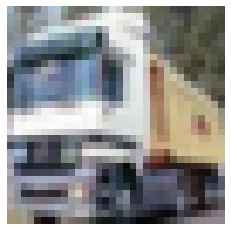

'truck'

In [24]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

## Test Drift

We need to accumulate a large enough batch size so no drift will be tested as yet.

In [27]:
!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 

We will now send 5000 requests to the model in batches. The drift detector will run at the end of this as we set the `drift_batch_size` to 5000 in our yaml above.

In [28]:
from tqdm.notebook import tqdm
for i in tqdm(range(0,5000,100)):
    X = X_train[i:i+100]
    predict(X)

Let's check the message dumper and extract the first drift result.

In [29]:
res=!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[0]))
print("Drift",j["data"]["is_drift"]==1)

Drift False


Now, let's create some CIFAR10 examples with motion blur.

In [30]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

E1110 15:45:08.551094 140080817293056 plot.py:39] Importing plotly failed. Interactive plots will not work.


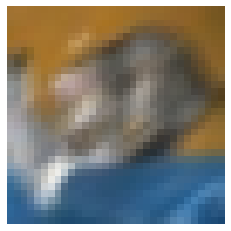

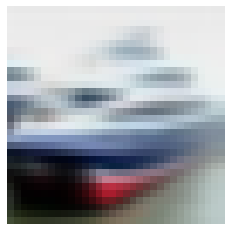

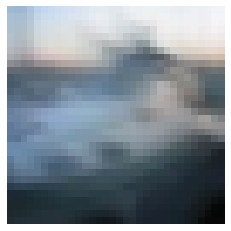

In [31]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])

Send these examples to the predictor.

In [32]:
for i in tqdm(range(0,5000,100)):
    X = X_corr[i:i+100]
    predict(X)

Now when we check the message dump we should find a new drift response.

In [33]:
res=!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Drift",j["data"]["is_drift"]==1)

Drift True


## Tear Down

In [34]:
!kubectl delete ns cifar10drift

namespace "cifar10drift" deleted
